# Install Important Libraries

In [1]:
!pip install ekphrasis
!pip install tweet-preprocessor
!pip install scikit-learn
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Important Libraries & Packages

In [1]:
# Mostly for Data Pre-processing
import re
import string
import pandas as pd
import time
import collections
import numpy as np

# important libraries for preprocessing & model creation using NLTK & scikit-learn
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from ekphrasis.classes.segmenter import Segmenter
import preprocessor as p
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# important libraries for EDA
import seaborn as sns
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sia_RTX3070\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sia_RTX3070\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sia_RTX3070\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sia_RTX3070\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
data = pd.read_csv('train.csv', encoding='ISO-8859-1')

## Exploratory Data Analysis (EDA)

In [4]:
# To get the shape of the dataset
data.shape

(99989, 3)

In [5]:
data.dtypes

ItemID            int64
Sentiment         int64
SentimentText    object
dtype: object

In [6]:
# Change Sentiment to Negative and Positive instead of 0 and 1
data['Sentiment'] = data['Sentiment'].replace({0: 'Negative', 1: 'Positive'})
data.head(5)

,ItemID,Sentiment,SentimentText
0,1,Negative,is so sad for my APL frie...
1,2,Negative,I missed the New Moon trail...
2,3,Positive,omg its already 7:30 :O
3,4,Negative,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,Negative,i think mi bf is cheating on me!!! ...


,ItemID,SentimentText
Sentiment,,
Negative,43532,43532
Positive,56457,56457


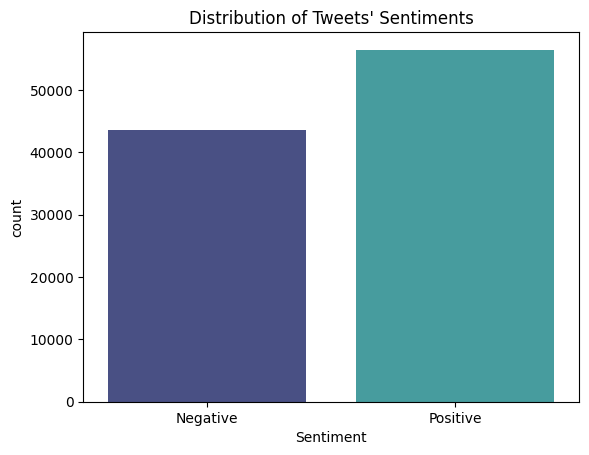

In [7]:
# To Check how many Negative and Positive Sentiment tweets are in the dataset.
sentiment_frequency = data.groupby('Sentiment').count()
display(sentiment_frequency)
print()
axis = sns.countplot(x = data['Sentiment'], palette = "mako").set(title = "Distribution of Tweets' Sentiments")

## Split Data into 20K

In [8]:
# Select 2.5k rows for each label
label_0_data = data[data['Sentiment'] == "Negative"].sample(n=10000, random_state=42)
label_1_data = data[data['Sentiment'] == "Positive"].sample(n=10000, random_state=42)

# Combine the selected data
selected_data = pd.concat([label_0_data, label_1_data])

# Shuffle the data
selected_data = selected_data.sample(frac=1, random_state=42)

# Save the selected data to a new file
selected_data.to_csv('20k_train.csv', index=False)

,ItemID,SentimentText
Sentiment,,
Negative,10000,10000
Positive,10000,10000


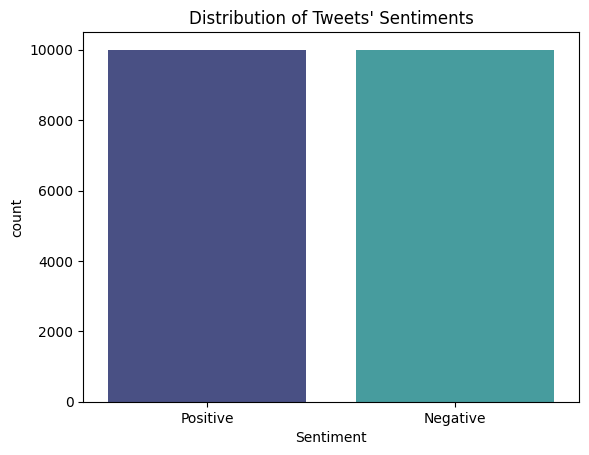

In [9]:
sentiment_frequency = selected_data.groupby('Sentiment').count()
display(sentiment_frequency)
axis = sns.countplot(x = selected_data['Sentiment'], palette = "mako").set(title = "Distribution of Tweets' Sentiments")

# Data Preprocessing

### Segment the Hashtags

In [10]:
selected_data["hashtag"] = selected_data["SentimentText"].apply(lambda x: re.findall(r"#(\w+)", x))

### Segmenter using the word statistics from Twitter

In [11]:
seg_tw = Segmenter(corpus='twitter')

Reading twitter - 1grams ...
Reading twitter - 2grams ...


C:\Users\Sia_RTX3070\anaconda3\envs\tenz\lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


### Text-Cleaning (URLs, Mentions, etc.)

In [12]:
for index, row in selected_data.iterrows():
    cleaned_text = p.clean(row["SentimentText"])
    selected_data.at[index, "CleanedText"] = cleaned_text

### Remove Digits and Lowercase the Text 

In [13]:
selected_data["CleanedText"] = selected_data["CleanedText"].apply(lambda x: re.sub(r'\d+', '', str(x)))
selected_data["CleanedText"] = selected_data["CleanedText"].str.lower()

### Remove Punctuations

In [14]:
def remove_punctuation(text):
    new_text = re.sub(r'[^\w\s]', '', text)
    return new_text

selected_data['CleanedText'] = selected_data['CleanedText'].apply(remove_punctuation)

### Perform word tokenization

In [15]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
selected_data.CleanedText = selected_data.CleanedText.apply(tokenizer.tokenize)

### Remove stop words

In [16]:
stop_tokens = nltk.corpus.stopwords.words("english")

def filter_stop_words(tweet):
    return [word for word in tweet if word not in stop_tokens]

selected_data.CleanedText = selected_data.CleanedText.apply(filter_stop_words)

### Perform lemmatization

In [17]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

def lemmatization(tweet):
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tweet]

selected_data.CleanedText = selected_data.CleanedText.apply(lemmatization)

## Show WordCloud for HashTags

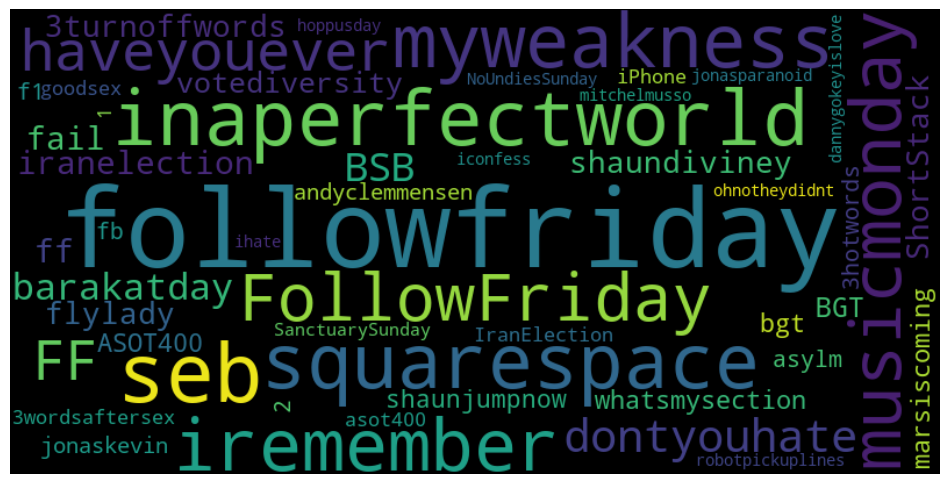

In [18]:
# Flatten the lists in 'hashtag' column
hashtags = [tag for sublist in selected_data['hashtag'] for tag in sublist]

# Frequency of words
fdist = FreqDist(hashtags)

# WordCloud
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist)

# Plotting the WordCloud
plt.figure(figsize=(12, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

### Remove Other Columns and only Retaining the Data and Label

In [19]:
columns_to_keep = ['Sentiment', 'CleanedText']
selected_data = selected_data[columns_to_keep]

## Saved Preprocessed Data in a different file.

In [20]:
selected_data.to_csv('preprocessed_data.csv', index=False)

### Feature Extraction 

In [21]:
# Find frequency of words used in reviews in the training data
all_words = []
for tweet in selected_data.CleanedText:
    for word in tweet:
        all_words.append(word)
all_words = list(nltk.FreqDist(all_words))
print("Number of unique words found: ", len(all_words))

# To limit the features that the classifier has to process
# Also to allow the machine learning model know which feature to focus on
# It is hypothesized words with higher frequency have greater impacts
# Take only 30% of most frequent words in the overall training data
word_features = all_words[:round(len(all_words)*0.30)]
print("\nNumber of features used: ", len(word_features))

# Returns a list of dictionary which maps unique words (feature) with their occurence (Boolean value)
# True if a word occurs in the review, and vice versa
def feature_extractor(tweet):
    words = set(tweet)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

dataset = list(zip(selected_data.CleanedText, selected_data.Sentiment))
feature_set = [(feature_extractor(tweet), Sentiment) for (tweet, Sentiment) in dataset]
print("\nLength of feature_set: ", len(feature_set))

Number of unique words found:  19201

Number of features used:  5760

Length of feature_set:  20000


## Train Test Data Split 

In [22]:
train_data, test_data = train_test_split(feature_set, test_size = 0.3, random_state = 42)
print("Length of train_data: ", len(train_data))
print("Length of test_data: ", len(test_data))

positive_count = 0
negative_count = 0

for features, sentiment in train_data:
    if sentiment == 'Positive':
        positive_count += 1
    elif sentiment == 'Negative':
        negative_count += 1

test_positive_count = 0
test_negative_count = 0
        
print("\n")
print("Train Data Sentiment Split:")
print("Number of positive instances:", positive_count)
print("Number of negative instances:", negative_count)
        
for features, sentiment in test_data:
    if sentiment == 'Positive':
        test_positive_count += 1
    elif sentiment == 'Negative':
        test_negative_count += 1

print("\n")
print("Test Data Sentiment Split:")
print("Number of positive instances:", test_positive_count)
print("Number of negative instances:", test_negative_count)

Length of train_data:  14000
Length of test_data:  6000


Train Data Sentiment Split:
Number of positive instances: 7060
Number of negative instances: 6940


Test Data Sentiment Split:
Number of positive instances: 2940
Number of negative instances: 3060


## Creating the Model Using Naive Bayes Model 

In [30]:
# Modelling - Build Naive Bayes model
import time
start_time = time.time()
classifier_NB = nltk.NaiveBayesClassifier.train(train_data)

# Model evaluation
# Accuracy
print("\nAccuracy: ", nltk.classify.accuracy(classifier_NB, test_data)*100)

# Get precision, recall and F1 Score
ref_set = collections.defaultdict(set)
test_set = collections.defaultdict(set)

for i, (features, label) in enumerate(test_data):
    ref_set[label].add(i)
    observed = classifier_NB.classify(features)
    test_set[observed].add(i)

# Record evaluation metrics in DataFrame
metrics_df = pd.DataFrame(columns = ["Class", "Precision", "Recall", "F1 Score"])
metrics_dict = {}

for Sentiment in ["Positive", "Negative"]:
    metrics_dict["Class"] = Sentiment
    metrics_dict["Precision"] = nltk.scores.precision(ref_set[Sentiment], test_set[Sentiment])
    metrics_dict["Recall"] = nltk.scores.recall(ref_set[Sentiment], test_set[Sentiment])
    metrics_dict["F1 Score"] = nltk.scores.f_measure(ref_set[Sentiment], test_set[Sentiment])
    metrics_df = metrics_df.append(metrics_dict, ignore_index=True)

metrics_df = metrics_df.set_index("Class")
display(metrics_df)

end_time = time.time()
duration = end_time - start_time
print("\nTotal duration of model training and evaluation: ", round(duration/60, 2), "minutes")


Accuracy:  70.36666666666666


C:\Users\Sia_RTX3070\AppData\Local\Temp\ipykernel_4220\3838718555.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics_dict, ignore_index=True)
C:\Users\Sia_RTX3070\AppData\Local\Temp\ipykernel_4220\3838718555.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics_dict, ignore_index=True)


,Precision,Recall,F1 Score
Class,,,
Positive,0.688514,0.721769,0.704749
Negative,0.719671,0.686275,0.702576



Total duration of model training and evaluation:  2.24 minutes


## Creating the Model using Multinomial Naive Bayes

In [31]:
# Split the train_data into features and labels
train_features = [features for features, label in train_data]
train_labels = [label for features, label in train_data]

# Encode the labels into a 1D array
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert the list of dictionaries into a numeric representation
vectorizer = DictVectorizer()
train_features_encoded = vectorizer.fit_transform(train_features)

# Define the parameter grid for grid search
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False]
}

# Create the Multinomial Naive Bayes classifier
classifier_MNB = MultinomialNB()

# Perform grid search
grid_search = GridSearchCV(classifier_MNB, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_features_encoded, train_labels_encoded)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Get the best classifier from grid search
best_MNB_classifier = grid_search.best_estimator_

# Prepare the test data in the correct format
test_features = [features for features, label in test_data]  # Extract features from test_data
test_features_encoded = vectorizer.transform(test_features)  # Convert test_features to a numeric representation

# Predict labels for the test data using the best classifier
predicted_labels_encoded = best_MNB_classifier.predict(test_features_encoded)

# Decode the predicted labels
predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)

# Calculate accuracy
accuracy = accuracy_score([label for features, label in test_data], predicted_labels)
print("Accuracy: ", accuracy*100)

# Get precision, recall, and F1 Score
ref_set = collections.defaultdict(set)
test_set = collections.defaultdict(set)

for i, (_, label) in enumerate(test_data):
    ref_set[label].add(i)
    test_set[predicted_labels[i]].add(i)

# Record evaluation metrics in DataFrame
metrics_df = pd.DataFrame(columns=["Class", "Precision", "Recall", "F1 Score"])
metrics_dict = {}

for Sentiment in ["Positive", "Negative"]:
    metrics_dict["Class"] = Sentiment
    metrics_dict["Precision"] = nltk.scores.precision(ref_set[Sentiment], test_set[Sentiment])
    metrics_dict["Recall"] = nltk.scores.recall(ref_set[Sentiment], test_set[Sentiment])
    metrics_dict["F1 Score"] = nltk.scores.f_measure(ref_set[Sentiment], test_set[Sentiment])
    metrics_df = metrics_df.append(metrics_dict, ignore_index=True)

metrics_df = metrics_df.set_index("Class")
display(metrics_df)

Best Parameters:  {'alpha': 2.0, 'fit_prior': True}
Best Score:  0.7127857142857141
Accuracy:  71.35000000000001


C:\Users\Sia_RTX3070\AppData\Local\Temp\ipykernel_4220\2958116574.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics_dict, ignore_index=True)
C:\Users\Sia_RTX3070\AppData\Local\Temp\ipykernel_4220\2958116574.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics_dict, ignore_index=True)


,Precision,Recall,F1 Score
Class,,,
Positive,0.711173,0.699320,0.705196
Negative,0.715664,0.727124,0.721349


## Creating the Model Using Logistic Regression Model

In [25]:
# Splitting the data for Train and Test
X = selected_data['CleanedText']
y = selected_data['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Without Grid Search 

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a CountVectorizer instance to convert text data into numerical vectors
vectorizer = CountVectorizer()

# Convert the training text data into feature vectors
X_train_vectors = vectorizer.fit_transform([' '.join(document) for document in X_train])

# Create a LogisticRegression model
LRModel = LogisticRegression()

# Train the logistic regression model
LRModel.fit(X_train_vectors, y_train)

# Convert the test text data into feature vectors using the same vectorizer
X_test_vectors = vectorizer.transform([' '.join(document) for document in X_test])

# Make predictions on the test data using the trained model
y_pred = LRModel.predict(X_test_vectors)

# Calculate evaluation metrics
LR_accuracy = accuracy_score(y_test, y_pred)
LR_precision_positive = precision_score(y_test, y_pred, pos_label='Positive')
LR_recall_positive = recall_score(y_test, y_pred, pos_label='Positive')
LR_f1_positive = f1_score(y_test, y_pred, pos_label='Positive')
LR_precision_negative = precision_score(y_test, y_pred, pos_label='Negative')
LR_recall_negative = recall_score(y_test, y_pred, pos_label='Negative')
LR_f1_negative = f1_score(y_test, y_pred, pos_label='Negative')

# Print evaluation results
print("Evaluation Results:")
print("----------------------")
print(f"Accuracy: {LR_accuracy*100:.2f}")
print("\n")
print("Positive")
print(f"Precision: {LR_precision_positive*100:.2f}")
print(f"Recall: {LR_recall_positive*100:.2f}")
print(f"F1 Score: {LR_f1_positive*100:.2f}")
print("\n")
print("Negative")
print(f"Precision: {LR_precision_negative*100:.2f}")
print(f"Recall: {LR_recall_negative*100:.2f}")
print(f"F1 Score: {LR_f1_negative*100:.2f}")


Evaluation Results:
----------------------
Accuracy: 71.35


Positive
Precision: 69.85
Recall: 73.06
F1 Score: 71.42


Negative
Precision: 72.92
Recall: 69.71
F1 Score: 71.28


### With Grid Search 

In [33]:
# Create a CountVectorizer instance to convert text data into numerical vectors
vectorizer = CountVectorizer()

# Convert the training text data into feature vectors
X_train_vectors = vectorizer.fit_transform([' '.join(document) for document in X_train])

# Create a LogisticRegression model
LRModel = LogisticRegression()

# Define the hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(LRModel, param_grid, cv=5)
grid_search.fit(X_train_vectors, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Get the best model from grid search
best_LR_model = grid_search.best_estimator_

# Convert the test text data into feature vectors using the same vectorizer
X_test_vectors = vectorizer.transform([' '.join(document) for document in X_test])

# Make predictions on the test data using the best model
y_pred = best_LR_model.predict(X_test_vectors)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision_positive = precision_score(y_test, y_pred, pos_label='Positive')
recall_positive = recall_score(y_test, y_pred, pos_label='Positive')
f1_positive = f1_score(y_test, y_pred, pos_label='Positive')
precision_negative = precision_score(y_test, y_pred, pos_label='Negative')
recall_negative = recall_score(y_test, y_pred, pos_label='Negative')
f1_negative = f1_score(y_test, y_pred, pos_label='Negative')

# Print evaluation results
print("Evaluation Results:")
print("----------------------")
print(f"Accuracy: {accuracy*100:.2f}")
print("\n")
print("Positive")
print(f"Precision: {precision_positive*100:.2f}")
print(f"Recall: {recall_positive*100:.2f}")
print(f"F1 Score: {f1_positive*100:.2f}")
print("\n")
print("Negative")
print(f"Precision: {precision_negative*100:.2f}")
print(f"Recall: {recall_negative*100:.2f}")
print(f"F1 Score: {f1_negative*100:.2f}")

C:\Users\Sia_RTX3070\anaconda3\envs\tenz\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sia_RTX3070\anaconda3\envs\tenz\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Best Parameters:  {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score:  0.7152857142857143
Evaluation Results:
----------------------
Accuracy: 71.3500


Positive
Precision: 69.85
Recall: 73.06
F1 Score: 71.42


Negative
Precision: 72.92
Recall: 69.71
F1 Score: 71.28


## Random Forest

### Without Grid Search

In [34]:
# Create a CountVectorizer instance to convert text data into numerical vectors
vectorizer = CountVectorizer()

# Convert the training text data into feature vectors
X_train_vectors = vectorizer.fit_transform([' '.join(document) for document in X_train])

# Create a Random Forest classifier with default parameters
RFModel = RandomForestClassifier()

# Fit the classifier on the training data
RFModel.fit(X_train_vectors, y_train)

# Convert the test text data into feature vectors using the same vectorizer
X_test_vectors = vectorizer.transform([' '.join(document) for document in X_test])

# Make predictions on the test data using the trained model
y_pred = RFModel.predict(X_test_vectors)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision_positive = precision_score(y_test, y_pred, pos_label='Positive')
recall_positive = recall_score(y_test, y_pred, pos_label='Positive')
f1_positive = f1_score(y_test, y_pred, pos_label='Positive')
precision_negative = precision_score(y_test, y_pred, pos_label='Negative')
recall_negative = recall_score(y_test, y_pred, pos_label='Negative')
f1_negative = f1_score(y_test, y_pred, pos_label='Negative')

# Print evaluation results
print("Evaluation Results:")
print("----------------------")
print(f"Accuracy: {accuracy*100:.2f}")
print("\n")
print("Positive")
print(f"Precision: {precision_positive*100:.2f}")
print(f"Recall: {recall_positive*100:.2f}")
print(f"F1 Score: {f1_positive*100:.2f}")
print("\n")
print("Negative")
print(f"Precision: {precision_negative*100:.2f}")
print(f"Recall: {recall_negative*100:.2f}")
print(f"F1 Score: {f1_negative*100:.2f}")


Evaluation Results:
----------------------
Accuracy: 71.50


Positive
Precision: 71.61
Recall: 69.32
F1 Score: 70.45


Negative
Precision: 71.40
Recall: 73.59
F1 Score: 72.48


### With Grid Search 

In [36]:
# Create a CountVectorizer instance to convert text data into numerical vectors
vectorizer = CountVectorizer()

# Convert the training text data into feature vectors
X_train_vectors = vectorizer.fit_transform([' '.join(document) for document in X_train])

# Create a Random Forest classifier
RFModel = RandomForestClassifier()

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 1000],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'max_leaf_nodes': [10, 100, 1000],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(RFModel, param_grid, cv=5)
grid_search.fit(X_train_vectors, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Get the best model from grid search
best_RF_model = grid_search.best_estimator_

# Convert the test text data into feature vectors using the same vectorizer
X_test_vectors = vectorizer.transform([' '.join(document) for document in X_test])

# Make predictions on the test data using the best model
y_pred = best_RF_model.predict(X_test_vectors)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision_positive = precision_score(y_test, y_pred, pos_label='Positive')
recall_positive = recall_score(y_test, y_pred, pos_label='Positive')
f1_positive = f1_score(y_test, y_pred, pos_label='Positive')
precision_negative = precision_score(y_test, y_pred, pos_label='Negative')
recall_negative = recall_score(y_test, y_pred, pos_label='Negative')
f1_negative = f1_score(y_test, y_pred, pos_label='Negative')

# Print evaluation results
print("Evaluation Results:")
print("----------------------")
print(f"Accuracy: {accuracy*100:.2f}")
print("\n")
print("Positive")
print(f"Precision: {precision_positive*100:.2f}")
print(f"Recall: {recall_positive*100:.2f}")
print(f"F1 Score: {f1_positive*100:.2f}")
print("\n")
print("Negative")
print(f"Precision: {precision_negative*100:.2f}")
print(f"Recall: {recall_negative*100:.2f}")
print(f"F1 Score: {f1_negative*100:.2f}")

Best Parameters:  {'max_depth': None, 'max_leaf_nodes': 1000, 'min_samples_split': 5, 'n_estimators': 1000}
Best Score:  0.7120714285714285
Evaluation Results:
----------------------
Accuracy: 71.52


Positive
Precision: 70.17
Recall: 72.82
F1 Score: 71.47


Negative
Precision: 72.91
Recall: 70.26
F1 Score: 71.56


## For Further Evaluation and Testing Purposes 

### Testing Inputs Preprocessing Function

In [33]:
def preprocess_text(text):
    # Clean URLs, mentions, etc.
    cleaned_text = p.clean(text)
    
    # Remove digits and lowercase the text
    cleaned_text = re.sub(r'\d+', '', str(cleaned_text))
    cleaned_text = cleaned_text.lower()
    
    # Remove punctuation
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    
    # Tokenize the text
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    tokens = tokenizer.tokenize(cleaned_text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    
    return tokens

# Helper function to get WordNet POS tags for lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


### Naive Bayes Testing

In [50]:
user_input = "I am so depressed."

# Preprocess the user input (assuming the input is stored in a variable called 'user_input')
preprocessed_input = preprocess_text(user_input)

# Extract features from the preprocessed user input
input_features = feature_extractor(preprocessed_input)

# Classify the user input
predicted_sentiment = classifier_NB.classify(input_features)

# Interpret the prediction
if predicted_sentiment == 'Positive':
    print("The sentiment of the input is positive.")
elif predicted_sentiment == 'Negative':
    print("The sentiment of the input is negative.")

The sentiment of the input is negative.


### Multinomial Naive Bayes Testing 

In [44]:
user_input = "@Ir4un you should take care of yourself."

# Preprocess the user input (assuming the input is stored in a variable called 'user_input')
preprocessed_input = preprocess_text(user_input)

# Extract features from the preprocessed user input
input_features = feature_extractor(preprocessed_input)

input_features_encoded = vectorizer.transform(input_features)

# Classify the user input
predicted_sentiment = best_MNB_classifier.predict(input_features_encoded)

# Replace 0 with Negative and 1 with Positive
predicted_sentiment = ["Negative" if sentiment == 0 else "Positive" for sentiment in predicted_sentiment]

# Interpret the prediction
if predicted_sentiment[0] == 'Positive':
    print("The sentiment of the input is positive.")
elif predicted_sentiment[0] == 'Negative':
    print("The sentiment of the input is negative.")

The sentiment of the input is positive.


### Logistic Regression Testing 

In [59]:
# Preprocess the new data (e.g., convert text to feature vectors)
X_test_vectors = vectorizer.transform(["I hate my life"])

# Make predictions with the trained model
predictions = best_LR_model.predict(X_test_vectors)

# Interpret the prediction
if predictions[0] == 'Positive':
    print("The sentiment of the input is positive.")
elif predictions[0] == 'Negative':
    print("The sentiment of the input is negative.")

The sentiment of the input is negative.


### Random Forest Testing 

In [61]:
# Assuming you have already trained the best_model using the optimized hyperparameters

# Preprocess the new data (e.g., convert text to feature vectors)
X_test_vectors = vectorizer.transform(["I love my life"])

# Make predictions with the trained model
predictions = best_RF_model.predict(X_test_vectors)

# Interpret the prediction
if predictions[0] == 'Positive':
    print("The sentiment of the input is positive.")
elif predictions[0] == 'Negative':
    print("The sentiment of the input is negative.")

The sentiment of the input is positive.
